In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [6]:
#import the data from a csv file.
data = pd.read_csv("Train.csv")

In [7]:
data.head(5)

,pickup_datetime,duration,pickup_x,pickup_y,dropoff_x,dropoff_y
0,2034-02-02 22:43:13,690,154.696567,325.477213,126.881573,322.211870
1,2034-01-30 16:30:13,399,160.754531,337.409138,156.181906,344.564970
2,2034-03-26 17:11:42,715,144.344672,330.828932,168.868622,372.795481
3,2034-03-07 23:45:27,566,122.749169,439.668599,131.837488,350.767551
4,2034-05-27 20:09:32,1565,184.348606,398.135385,104.896974,332.185639


In [8]:
data = data[data.duration != 0]

In [9]:
columns = ["pickup_datetime", "duration" ,"pickup_x" ,"pickup_y" ,"dropoff_x" ,"dropoff_y"]
data = data[columns]

In [10]:
data.shape

(1299993, 6)

In [11]:
data.isna().sum()

pickup_datetime    0
duration           0
pickup_x           0
pickup_y           0
dropoff_x          0
dropoff_y          0
dtype: int64

In [12]:
#Convert timestamp to datetime format to fetch the other details as listed below
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_datetime'].head()

0   2034-02-02 22:43:13
1   2034-01-30 16:30:13
2   2034-03-26 17:11:42
3   2034-03-07 23:45:27
4   2034-05-27 20:09:32
Name: pickup_datetime, dtype: datetime64[ns]

In [13]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
data['weekday'] = data.pickup_datetime.dt.weekday_name
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

In [14]:
data.head()

,pickup_datetime,duration,pickup_x,pickup_y,dropoff_x,dropoff_y,weekday,month,weekday_num,pickup_hour
0,2034-02-02 22:43:13,690,154.696567,325.477213,126.881573,322.211870,Thursday,2,3,22
1,2034-01-30 16:30:13,399,160.754531,337.409138,156.181906,344.564970,Monday,1,0,16
2,2034-03-26 17:11:42,715,144.344672,330.828932,168.868622,372.795481,Sunday,3,6,17
3,2034-03-07 23:45:27,566,122.749169,439.668599,131.837488,350.767551,Tuesday,3,1,23
4,2034-05-27 20:09:32,1565,184.348606,398.135385,104.896974,332.185639,Saturday,5,5,20


In [15]:
data['weekday'].unique()

array(['Thursday', 'Monday', 'Sunday', 'Tuesday', 'Saturday', 'Friday',
       'Wednesday'], dtype=object)

In [16]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_x'], df['pickup_y'])
    drop = (df['dropoff_x'], df['dropoff_y'])
    return haversine(pickup, drop)

In [17]:
#Calculate distance and assign new column to the dataframe.
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

In [18]:
#Calculate Speed in km/h for further insights
data['speed'] = (data.distance/(data.duration))

In [19]:
#Check the type of each variable
data.dtypes.reset_index()

,index,0
0,pickup_datetime,datetime64[ns]
1,duration,int64
2,pickup_x,float64
3,pickup_y,float64
4,dropoff_x,float64
5,dropoff_y,float64
6,weekday,object
7,month,int64
8,weekday_num,int64
9,pickup_hour,int64


In [20]:
data.head()

,pickup_datetime,duration,pickup_x,pickup_y,dropoff_x,dropoff_y,weekday,month,weekday_num,pickup_hour,distance,speed
0,2034-02-02 22:43:13,690,154.696567,325.477213,126.881573,322.211870,Thursday,2,3,22,3104.896536,4.499850
1,2034-01-30 16:30:13,399,160.754531,337.409138,156.181906,344.564970,Monday,1,0,16,897.689508,2.249848
2,2034-03-26 17:11:42,715,144.344672,330.828932,168.868622,372.795481,Sunday,3,6,17,5019.849155,7.020768
3,2034-03-07 23:45:27,566,122.749169,439.668599,131.837488,350.767551,Tuesday,3,1,23,5636.331507,9.958183
4,2034-05-27 20:09:32,1565,184.348606,398.135385,104.896974,332.185639,Saturday,5,5,20,9808.795722,6.267601


In [21]:
data[['month', 'weekday_num', 'pickup_hour']] = data[['month', 'weekday_num', 'pickup_hour']].astype(str)

In [22]:
#Check the type of each variable
data.dtypes.reset_index()

,index,0
0,pickup_datetime,datetime64[ns]
1,duration,int64
2,pickup_x,float64
3,pickup_y,float64
4,dropoff_x,float64
5,dropoff_y,float64
6,weekday,object
7,month,object
8,weekday_num,object
9,pickup_hour,object


In [23]:
dummy = pd.get_dummies(data.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

In [24]:
data.columns

Index(['pickup_datetime', 'duration', 'pickup_x', 'pickup_y', 'dropoff_x',
       'dropoff_y', 'weekday', 'month', 'weekday_num', 'pickup_hour',
       'distance', 'speed', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'weekday_num_1', 'weekday_num_2', 'weekday_num_3',
       'weekday_num_4', 'weekday_num_5', 'weekday_num_6', 'pickup_hour_1',
       'pickup_hour_10', 'pickup_hour_11', 'pickup_hour_12', 'pickup_hour_13',
       'pickup_hour_14', 'pickup_hour_15', 'pickup_hour_16', 'pickup_hour_17',
       'pickup_hour_18', 'pickup_hour_19', 'pickup_hour_2', 'pickup_hour_20',
       'pickup_hour_21', 'pickup_hour_22', 'pickup_hour_23', 'pickup_hour_3',
       'pickup_hour_4', 'pickup_hour_5', 'pickup_hour_6', 'pickup_hour_7',
       'pickup_hour_8', 'pickup_hour_9'],
      dtype='object')

In [25]:
data['distance'].describe()

count    1.299993e+06
mean     3.040052e+03
std      2.667934e+03
min      6.379998e-01
25%      1.282043e+03
50%      2.155056e+03
75%      3.788486e+03
max      1.995999e+04
Name: distance, dtype: float64

# Univariate analysis

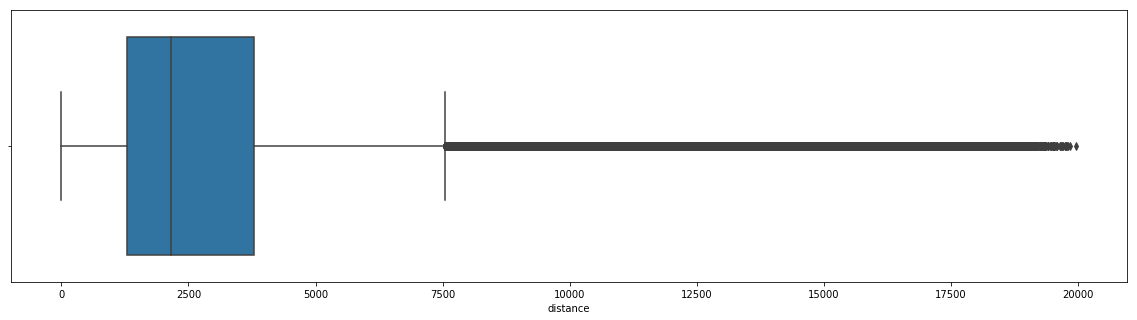

In [26]:
plt.figure(figsize = (20,5))
sns.boxplot(data.distance)
plt.show()

In [27]:
data.distance.min()

0.6379998234296524

In [28]:
data.distance.max()

19959.990180820434

In [29]:
data.distance.describe()

count    1.299993e+06
mean     3.040052e+03
std      2.667934e+03
min      6.379998e-01
25%      1.282043e+03
50%      2.155056e+03
75%      3.788486e+03
max      1.995999e+04
Name: distance, dtype: float64

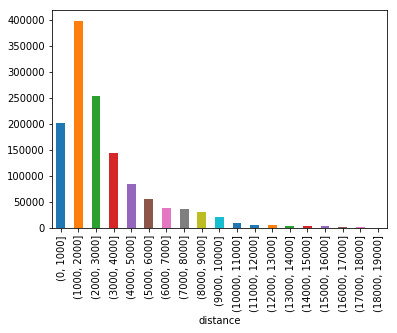

In [30]:
data.distance.groupby(pd.cut(data.distance, np.arange(0,20000,1000))).count().plot(kind='bar')
plt.show()

mean distance travelled is approx 3 kms.
standard deviation of 2.6 which shows that most of the trips are limited to the range of 1-10 kms.

# Duration

In [31]:
data.duration.describe()

count    1.299993e+06
mean     6.980620e+02
std      5.535143e+02
min      1.000000e+00
25%      3.310000e+02
50%      5.510000e+02
75%      8.940000e+02
max      1.784200e+04
Name: duration, dtype: float64

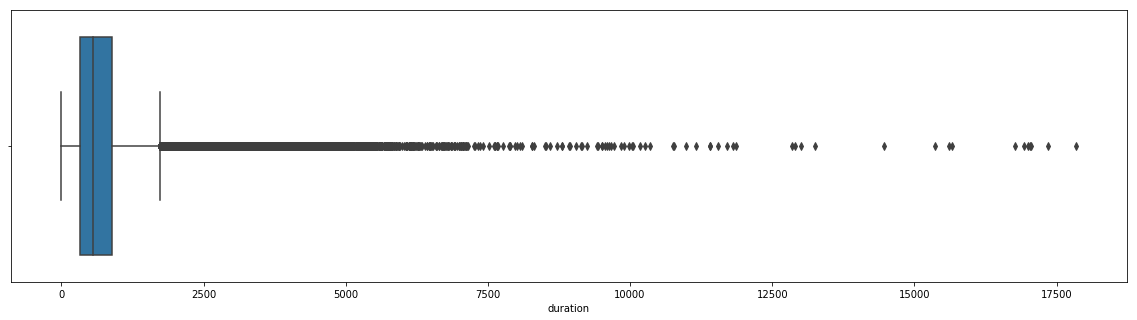

In [32]:
plt.figure(figsize = (20,5))
sns.boxplot(data.duration)
plt.show()

Major trip durations took between 10-20 mins to complete.

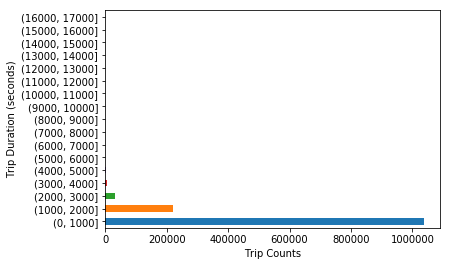

In [33]:
data.duration.groupby(pd.cut(data.duration, np.arange(0,18000,1000))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

Shows duration vs no of trips

In [34]:
#data.duration.groupby(pd.cut(data.duration, np.arange(1,max(data.duration),1000))).count()

In [35]:
data.speed.describe()

count    1.299993e+06
mean     4.684839e+00
std      3.415268e+00
min      3.484343e-03
25%      3.080250e+00
50%      4.246442e+00
75%      5.754550e+00
max      2.169718e+03
Name: speed, dtype: float64

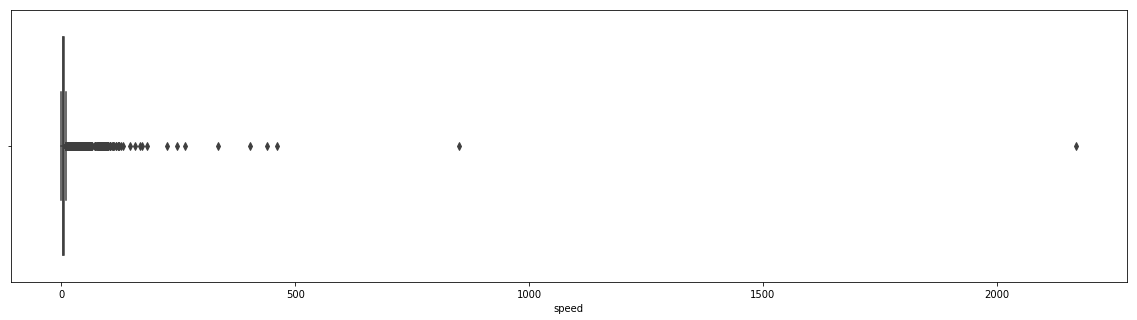

In [36]:
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

mean speed of the trip is 4.67 unit/sec

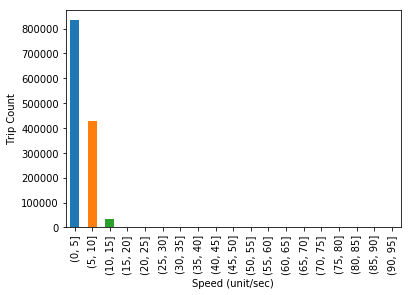

In [37]:
data.speed.groupby(pd.cut(data.speed, np.arange(0,100,5))).count().plot(kind = 'bar')
plt.xlabel('Speed (unit/sec)')
plt.ylabel('Trip Count')
plt.show()

Total trips in each hour

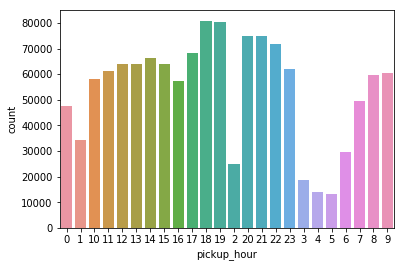

In [38]:
sns.countplot(data.pickup_hour)
plt.show()

Total trips per week

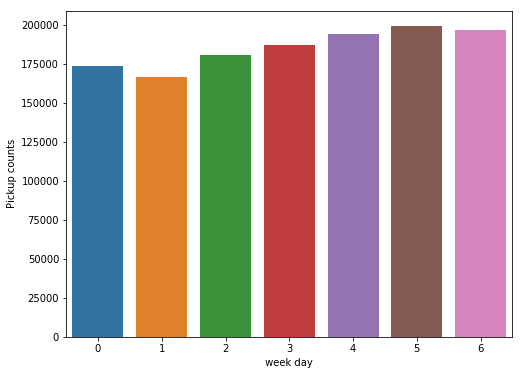

In [39]:
plt.figure(figsize = (8,6))
sns.countplot(data.weekday_num)
plt.xlabel(' week day ')
plt.ylabel('Pickup counts')
plt.show()

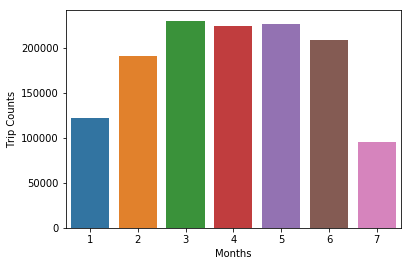

In [40]:
sns.countplot(data.month)
plt.ylabel('Trip Counts')
plt.xlabel('Months')
plt.show()

# BiVariate Analysis

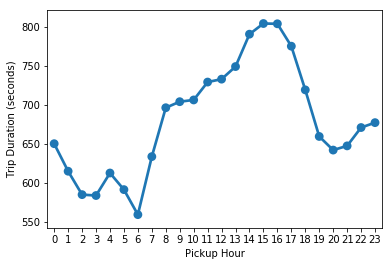

In [41]:
group1 = data.groupby('pickup_hour').duration.mean()
sns.pointplot(group1.index, group1.values, order =["0" ,"1" , "2", "3" , "4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23"])
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

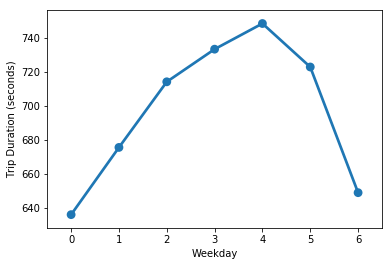

In [42]:
group2 = data.groupby('weekday_num').duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

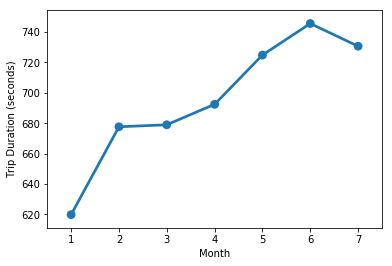

In [43]:
group3 = data.groupby('month').duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

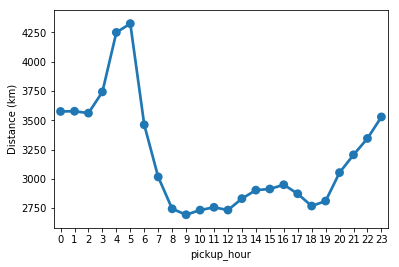

In [44]:
group5 = data.groupby('pickup_hour').distance.mean()
sns.pointplot(group5.index, group5.values, order =["0" ,"1" , "2", "3" , "4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23"])
plt.ylabel('Distance (km)')
plt.show()

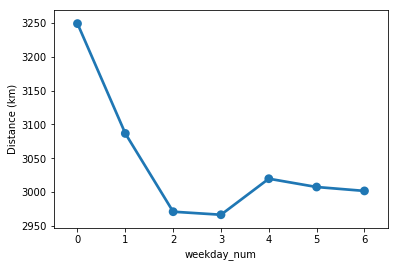

In [45]:
group6 = data.groupby('weekday_num').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (km)')
plt.show()

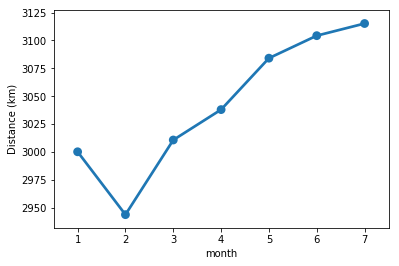

In [46]:
group7 = data.groupby('month').distance.mean()
sns.pointplot(group7.index, group7.values)
plt.ylabel('Distance (km)')
plt.show()

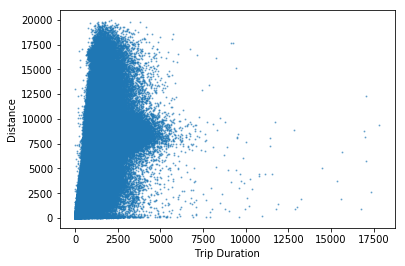

In [47]:
plt.scatter(data.duration, data.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

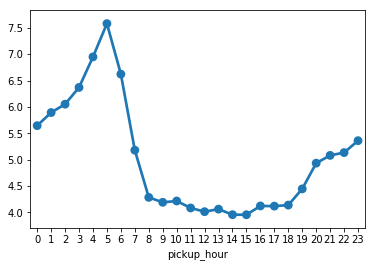

In [48]:
group9 = data.groupby('pickup_hour').speed.mean()
sns.pointplot(group9.index, group9.values, order =["0" ,"1" , "2", "3" , "4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23"])
plt.show()

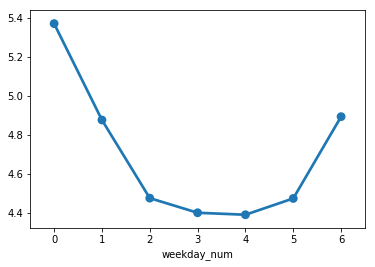

In [49]:
group10 = data.groupby('weekday_num').speed.mean()
sns.pointplot(group10.index, group10.values)
plt.show()

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299993 entries, 0 to 1299999
Data columns (total 47 columns):
pickup_datetime    1299993 non-null datetime64[ns]
duration           1299993 non-null int64
pickup_x           1299993 non-null float64
pickup_y           1299993 non-null float64
dropoff_x          1299993 non-null float64
dropoff_y          1299993 non-null float64
weekday            1299993 non-null object
month              1299993 non-null object
weekday_num        1299993 non-null object
pickup_hour        1299993 non-null object
distance           1299993 non-null float64
speed              1299993 non-null float64
month_2            1299993 non-null uint8
month_3            1299993 non-null uint8
month_4            1299993 non-null uint8
month_5            1299993 non-null uint8
month_6            1299993 non-null uint8
month_7            1299993 non-null uint8
weekday_num_1      1299993 non-null uint8
weekday_num_2      1299993 non-null uint8
weekday_num_3      129

In [51]:
Col1 = ["pickup_x", "pickup_y","dropoff_x", "dropoff_y", "weekday","pickup_datetime", "duration"]
X_train = data.drop(Col1, axis =1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299993 entries, 0 to 1299999
Data columns (total 40 columns):
month             1299993 non-null object
weekday_num       1299993 non-null object
pickup_hour       1299993 non-null object
distance          1299993 non-null float64
speed             1299993 non-null float64
month_2           1299993 non-null uint8
month_3           1299993 non-null uint8
month_4           1299993 non-null uint8
month_5           1299993 non-null uint8
month_6           1299993 non-null uint8
month_7           1299993 non-null uint8
weekday_num_1     1299993 non-null uint8
weekday_num_2     1299993 non-null uint8
weekday_num_3     1299993 non-null uint8
weekday_num_4     1299993 non-null uint8
weekday_num_5     1299993 non-null uint8
weekday_num_6     1299993 non-null uint8
pickup_hour_1     1299993 non-null uint8
pickup_hour_10    1299993 non-null uint8
pickup_hour_11    1299993 non-null uint8
pickup_hour_12    1299993 non-null uint8
pickup_hour_13    1

# Feature Selection

In [52]:
list(zip( range(0,len(data.columns)),data.columns))

[(0, 'pickup_datetime'),
 (1, 'duration'),
 (2, 'pickup_x'),
 (3, 'pickup_y'),
 (4, 'dropoff_x'),
 (5, 'dropoff_y'),
 (6, 'weekday'),
 (7, 'month'),
 (8, 'weekday_num'),
 (9, 'pickup_hour'),
 (10, 'distance'),
 (11, 'speed'),
 (12, 'month_2'),
 (13, 'month_3'),
 (14, 'month_4'),
 (15, 'month_5'),
 (16, 'month_6'),
 (17, 'month_7'),
 (18, 'weekday_num_1'),
 (19, 'weekday_num_2'),
 (20, 'weekday_num_3'),
 (21, 'weekday_num_4'),
 (22, 'weekday_num_5'),
 (23, 'weekday_num_6'),
 (24, 'pickup_hour_1'),
 (25, 'pickup_hour_10'),
 (26, 'pickup_hour_11'),
 (27, 'pickup_hour_12'),
 (28, 'pickup_hour_13'),
 (29, 'pickup_hour_14'),
 (30, 'pickup_hour_15'),
 (31, 'pickup_hour_16'),
 (32, 'pickup_hour_17'),
 (33, 'pickup_hour_18'),
 (34, 'pickup_hour_19'),
 (35, 'pickup_hour_2'),
 (36, 'pickup_hour_20'),
 (37, 'pickup_hour_21'),
 (38, 'pickup_hour_22'),
 (39, 'pickup_hour_23'),
 (40, 'pickup_hour_3'),
 (41, 'pickup_hour_4'),
 (42, 'pickup_hour_5'),
 (43, 'pickup_hour_6'),
 (44, 'pickup_hour_7'),
 (45

In [53]:
Y = data.iloc[:,1].values #duration , target
X = data.iloc[:,range(10,47)].values #Train features
X.shape

(1299993, 37)

In [54]:
Y

array([ 690,  399,  715, ...,  743, 1124, 2423])

In [55]:
print("Let's append {} rows of 1's as the first column in the X array".format(X.shape[0]))


Let's append 1299993 rows of 1's as the first column in the X array


In [56]:
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)
X1.shape

(1299993, 38)

In [57]:
X_opt = X1[:,range(0,37)]
regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()

#Fetch p values for each feature
p_Vals = regressor_OLS.pvalues

#define significance level for accepting the feature.
sig_Level = 0.01

regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                 6.461e+04
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:12:12   Log-Likelihood:            -9.3890e+06
No. Observations:             1299993   AIC:                         1.878e+07
Df Residuals:                 1299956   BIC:                         1.878e+07
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        289.7148      1.631    177.628      0.000     286.518     292.912
x1             0.1686      0.000   1487.143      0.000       0.168       0.169
x2           -49.1944      0.091   -543.146      0.000     -49.372     -49.017
x3            40.4742      1.215     33.322      0.000      38.094      42.855
x4            34.0396      1.175     28.965      0.000      31.736      36.343
x5            46.5715      1.178     39.526      0.000      44.262      48.881
x6            68.9892      1.178     58.588      0.000      66.681      71.297
x7            79.3062      1.197     66.280      0.000      76.961      81.651
x8            72.1185      1.434     50.289      0.000      69.308      74.929
x9            34.4606      1.148     30.026      0.000      32.211      36.710
x10           72.7072      1.129     64.384      0.000      70.494      74.920
x11           90.6166      1.121     80.866      0.000      88.420      92.813
x12           98.0457      1.111     88.287      0.000      95.869     100.222
x13           84.4875      1.099     76.854      0.000      82.333      86.642
x14           33.9768      1.094     31.061      0.000      31.833      36.121
x15          -83.2242      2.061    -40.385      0.000     -87.263     -79.185
x16           52.6036      1.705     30.857      0.000      49.262      55.945
x17           66.5277      1.680     39.600      0.000      63.235      69.820
x18           71.1769      1.656     42.981      0.000      67.931      74.423
x19           73.5345      1.657     44.387      0.000      70.288      76.782
x20           96.9577      1.638     59.189      0.000      93.747     100.168
x21          109.9846      1.656     66.420      0.000     106.739     113.230
x22          113.0618      1.715     65.941      0.000     109.701     116.422
x23           95.5296      1.624     58.841      0.000      92.348      98.712
x24           56.1253      1.544     36.360      0.000      53.100      59.151
x25            2.5618      1.545      1.658      0.097      -0.467       5.590
x26          -98.3668      2.339    -42.046      0.000    -102.952     -93.781
x27          -32.7036      1.578    -20.723      0.000     -35.797     -29.611
x28          -46.7524      1.577    -29.639      0.000     -49.844     -43.661
x29          -44.4531      1.598    -27.821      0.000     -47.585     -41.321
x30          -58.4155      1.672    -34.937      0.000     -61.693     -55.138
x31         -112.9108      2.639    -42.783      0.000    -118.084    -107.738
x32         -146.2757      2.992    -48.896      0.000    -152.139    -140.412
x33         -165.9966      3.046    -54.488      0.000    -171.968    -160.026
x34         -107.8694      2.180    -49.474      0.000    -112.143    -103.596
x35          -30.6034      1.803    -16.974      0.000     -34.137     -27.070
x3

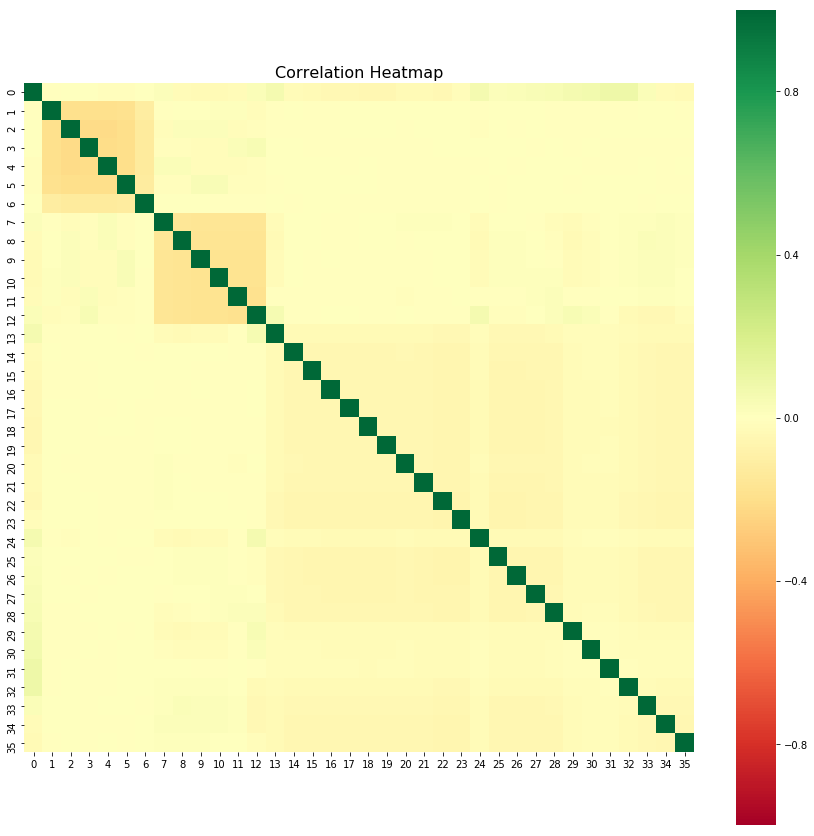

In [58]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X[:,1:]).corr()
corr.index = pd.DataFrame(X[:,1:]).columns
sns.heatmap(corr, vmin=-1, vmax=1,cmap='RdYlGn', square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [59]:
#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size=0.2)

#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

In [60]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,Y, random_state=4, test_size=0.2)

Scale Data

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

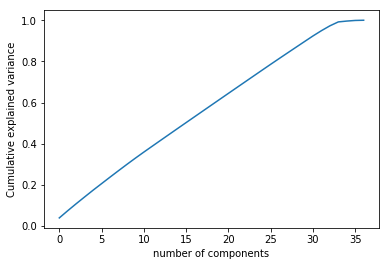

In [62]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [63]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 3.8899999999999997),
 (2, 7.3999999999999995),
 (3, 10.8),
 (4, 14.11),
 (5, 17.38),
 (6, 20.549999999999997),
 (7, 23.72),
 (8, 26.84),
 (9, 29.93),
 (10, 32.95),
 (11, 35.900000000000006),
 (12, 38.78000000000001),
 (13, 41.650000000000006),
 (14, 44.52),
 (15, 47.38),
 (16, 50.230000000000004),
 (17, 53.080000000000005),
 (18, 55.92000000000001),
 (19, 58.76000000000001),
 (20, 61.600000000000016),
 (21, 64.44000000000001),
 (22, 67.27000000000001),
 (23, 70.10000000000001),
 (24, 72.93),
 (25, 75.76),
 (26, 78.57000000000001),
 (27, 81.35000000000001),
 (28, 84.12),
 (29, 86.87),
 (30, 89.62),
 (31, 92.35000000000001),
 (32, 94.92000000000002),
 (33, 97.27000000000001),
 (34, 99.19000000000001),
 (35, 99.60000000000001),
 (36, 99.9)]

In [64]:
pca_10 = PCA(n_components=33)
X_train_pca = pca_10.fit_transform(X_train_pca)
X_test_pca = pca_10.transform(X_test_pca)

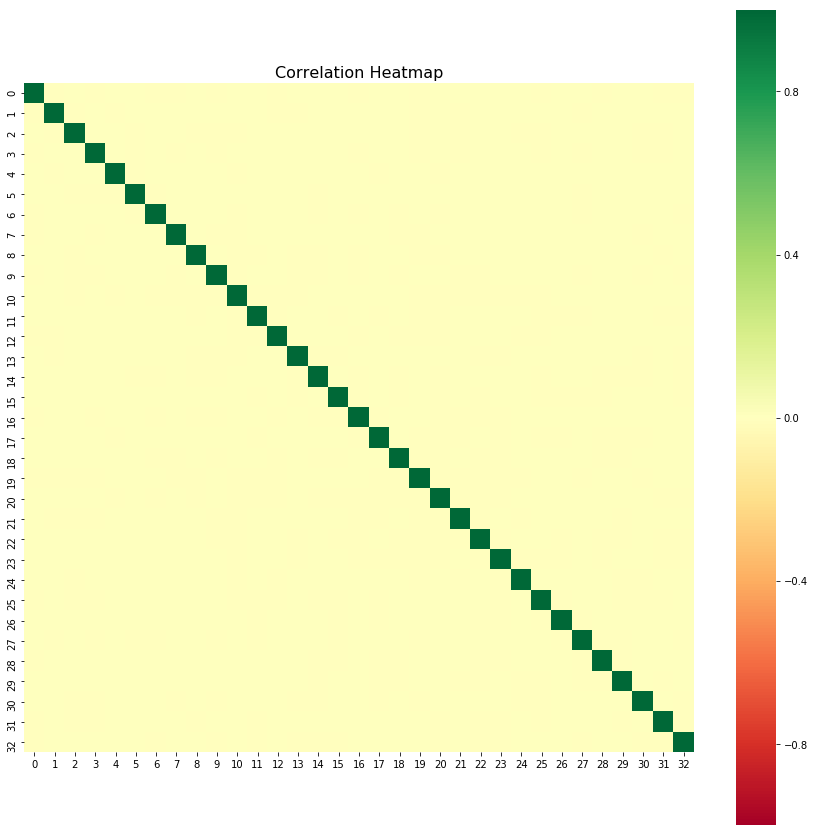

In [65]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_pca).corr()
corr.index = pd.DataFrame(X_train_pca).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [66]:
regressor = LinearRegression() 
regressor.fit(X_train,y_train) 

#Linear regressor for the Feature selection group
regressor1 = LinearRegression() 
regressor1.fit(X_train_fs,y_train_fs) 

#Linear regressor for the Feature extraction group
regressor2 = LinearRegression() 
regressor2.fit(X_train_pca,y_train_pca)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [67]:
#Predict from the test features of raw data
y_pred = regressor.predict(X_test) 

#Predict from the test features of Feature Selection group
y_pred = regressor1.predict(X_test_fs) 

#Predict from the test features of Feature Extraction group
y_pred_pca = regressor2.predict(X_test_pca) 

In [68]:
print('RMSE score for the Multiple LR raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('Variance score for the Multiple LR raw is : %.2f' % regressor.score(X_test, y_test))
print("\n")

#Evaluate the regressor on the Feature selection group
print('RMSE score for the Multiple LR FS is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred))))
print('Variance score for the Multiple LR FS is : %.2f' % regressor1.score(X_test_fs, y_test_fs))
print("\n")

print('RMSE score for the Multiple LR PCA is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca,y_pred_pca))))
print('Variance score for the Multiple LR PCA is : %.2f' % regressor2.score(X_test_pca, y_test_pca))

RMSE score for the Multiple LR raw is : 320.57187239197054
Variance score for the Multiple LR raw is : 0.66


RMSE score for the Multiple LR FS is : 320.57187239197054
Variance score for the Multiple LR FS is : 0.66


RMSE score for the Multiple LR PCA is : 440.98963197027706
Variance score for the Multiple LR PCA is : 0.36


In [69]:
X_train.shape

(1039994, 37)

In [70]:
#Find linear correlation of each feature with the target variable
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((X_train,y_train.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:37].columns.tolist()
target = df1.iloc[:,37].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
0 vs 37,0.718902
1 vs 37,-0.117446
20 vs 37,0.043720
21 vs 37,0.040842
33 vs 37,-0.038616
19 vs 37,0.038538
6 vs 37,0.037664
13 vs 37,-0.037562
11 vs 37,0.037470
22 vs 37,0.033508


# Random Forest

In [71]:
# specify parameters and distributions to sample from
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [72]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from time import time

In [73]:
regr1 = RandomForestRegressor()#max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)


In [75]:
param_dist = {"max_depth": [3, None],
              "max_features": ['sqrt' , 'log2' ],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "n_estimators":[35,40,45]
              }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(regr1, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 2317.94 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.965 (std: 0.003)
Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 40}

Model with rank: 2
Mean validation score: 0.965 (std: 0.002)
Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 40}

Model with rank: 3
Mean validation score: 0.964 (std: 0.003)
Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 45}



In [76]:
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.965 (std: 0.003)
Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 40}

Model with rank: 2
Mean validation score: 0.965 (std: 0.002)
Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 40}

Model with rank: 3
Mean validation score: 0.964 (std: 0.003)
Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 45}



# XGBoost

In [77]:
import xgboost as xgb

In [78]:
x_model = xgb.XGBRegressor()
param_dist = {"max_depth": [3, 4,5],
              "min_child_weight": [3, 4,5,6],
              "gamma":[0,0.1,0.2],
              "colsample_bytree":[0.7,0.8,0.9],
              "nthread":[3,4,5]
              }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(x_model, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 7466.57 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.998 (std: 0.000)
Parameters: {'nthread': 4, 'min_child_weight': 3, 'max_depth': 5, 'gamma': 0.1, 'colsample_bytree': 0.9}

Model with rank: 2
Mean validation score: 0.997 (std: 0.000)
Parameters: {'nthread': 3, 'min_child_weight': 4, 'max_depth': 4, 'gamma': 0.1, 'colsample_bytree': 0.9}

Model with rank: 2
Mean validation score: 0.997 (std: 0.000)
Parameters: {'nthread': 3, 'min_child_weight': 4, 'max_depth': 4, 'gamma': 0.2, 'colsample_bytree': 0.9}

